# Transcription

Transcription of audio into a musical representation is not a completely objective process. The kind of transcription and the methods used depend heavily on the purpose of the transcription, on what it will be used for. Within **maelzel** there is a `transcribe` package which implements multiple transcription strategies

## Voice Analysis / Transcription

When transcribing a voice, which is a monophonic source with highly harmonic timbre for the pitched parts of speech/song, probably the most appropriate transcription method is based on the analysis of the fundamental frequency in combination with onset/offset prediction and other secondary features. 

`maelzel.transcribe.FundamentalAnalysisMono` implements the skeleton of such an approach:

1. Onset detection
2. The fundamental is sampled within each onset-offset timespan to include any pitch inflections. 
3. A list of "gestures" is generated, where each gestures consists on a series of breakpoints. A breakpoint has information regarding pitch, amplitude, voicedness and other features at a given time
4. Unpitched sections are analyzed using secondary features, like centroid, to characterize them with more detail.


**TODO**: it might be desirable to extend the analysis of the unpitched sections using more detailed features like `mfb` or `mfcc`. For voice transcription it would also be relevant to perform formant analysis and vowel/phoneme prediction to enrich the transcription



In [1]:
from maelzel.snd.audiosample import Sample
from maelzel import transcribe
from maelzel.core import *
import matplotlib.pyplot as plt


## Configuration

When performing automatic transcription the quantization results tend to become very complex. For this reason it is important to limit the complexity allowed by the quantization algorithm in order to keep the results readable. As it will be seen later the resulting transcription remains very close to the original, even with the lowest complexity quantization. 

In [2]:
cfg = getConfig()
cfg['quant.complexity'] = 'low'
cfg['show.centsDeviationAsTextAnnotation'] = False
cfg['show.horizontalSpacing'] = 'large'
cfg['show.lilypondGlissandoMinimumLength'] = 3

Sample(dur=20.0, sr=44100, ch=1)
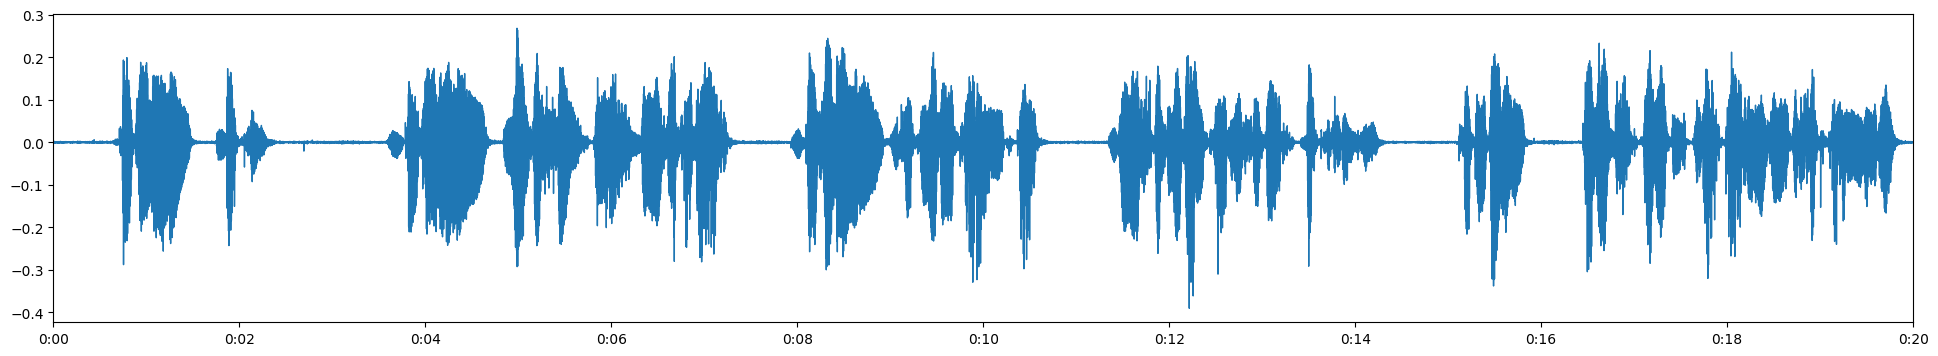

In [3]:
# s = Sample('../snd/Numbers_EnglishFemale.flac')
# s = Sample('../snd/colours-german-male.flac')
# s = Sample("~/tmp/gliss.flac")
# s = Sample('../snd/finneganswake-fragm01.flac')

# s = Sample('../snd/voiceover-fragment-48k.flac')
s = Sample('../notebooks/snd/istambul2.flac')


# Only the left channel
s0 = s.getChannel(0, contiguous=True)
s0

Now we perform the analysis itself. There are many parameters which can be customized but in general the defaults tend to produce viable results. The analysis is then plotted to show utterances split by onsets. Within each onset-offset range the predicted (and already simplified) fundamental is shown as a line. Zero-frequency sections represent onsets for where the confidence of the fundamental pitch prediction was too low.

LibXtract compiled with ooura FFT


mnOut size: 6891
m_pitchTrack size: 6891


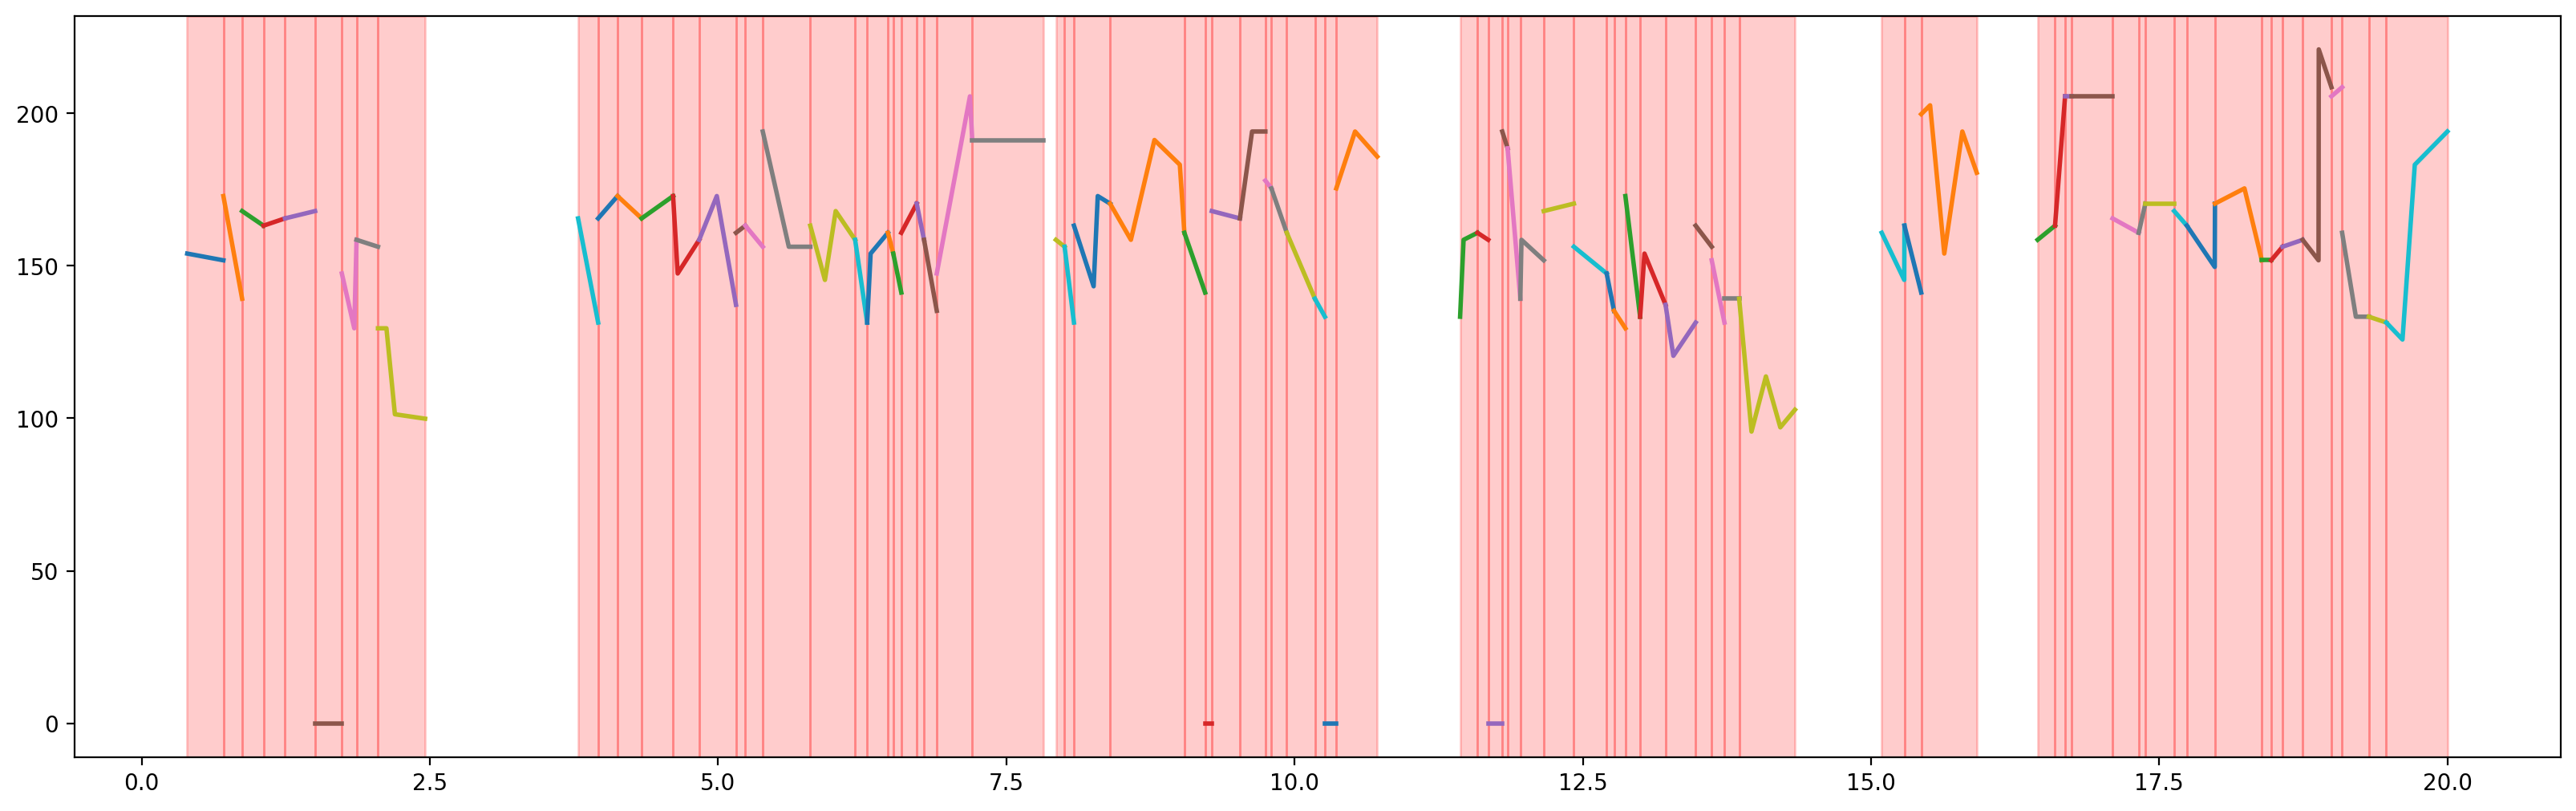

In [4]:
analysis = transcribe.FundamentalAnalysisMono(s0.samples, 
                                              sr=s0.sr, 
                                              # Quantize the pitch to its nearest 1/8th tone
                                              semitoneQuantization=4, 
                                              minSilence=0.001, 
                                              # Mark which are the most salient onsets
                                              accentPercentile=0.1, 
                                              # Simplify the pitch contour
                                              simplify=0.15, 
                                              onsetThreshold=0.05, 
                                              minFrequency=50, 
                                              overlap=16, 
                                              markLowFrequenciesAsUnvoiced=False, 
                                              # Unvoiced utterances softer than this are not taken into 
                                              # consideration since they are often oart of the
                                              # background noise
                                              unvoicedMinAmplitudePercentile=0.3,
                                              onsetOverlap=8, 
                                              onsetBacktrack=True)
plt.figure(figsize=(20, 6))
analysis.plot(spanAlpha=0.2)


The analysis contains a series of breakpoints.These breakpoints are grouped by onset/offset region and stored in the `.groups` attribute within the analysis. A group contains all the breakpoints between an onset and the next onset. Notice that a group can have an offset or not. A group without an offset indicates that there is no interruption between the end of one group and the start of the next. Keep in mind that onset prediction is performed based on spectral flow: an onset indicates a significant change of spectrum within a given period of time. 

In [5]:
analysis

time,freq,amp,voiced,linked,strength,strengthPercentile,freqConfidence,ampPercentile,kind,isaccent,duration
0.3947,154.0302,0.0012,False,True,0.3751,0.0368,0.0000,0.1013,onset,False,0.3135
0.7082,151.8219,0.1181,False,False,8.0438,0.7901,0.0000,0.9665,,False,0.0000
0.7082,172.8930,0.1181,False,True,8.0438,0.7901,0.0000,0.9665,onset,True,0.1625
0.8707,139.2213,0.1047,False,False,2.4267,0.2384,0.0000,0.9435,,False,0.0000
0.8707,167.9711,0.1047,False,True,2.4267,0.2384,0.0000,0.9435,onset,True,0.1858
1.0565,163.1893,0.1097,True,False,0.8343,0.0820,0.7343,0.9524,,False,0.0000
1.0565,163.1893,0.1097,True,True,0.8343,0.0820,0.7343,0.9524,onset,False,0.1858
1.2423,165.5629,0.1000,True,False,1.1559,0.1135,0.5815,0.9348,,False,0.0000
1.2423,165.5629,0.1000,True,True,1.1559,0.1135,0.5815,0.9348,onset,True,0.2612
1.5035,167.9711,0.0013,False,False,1.7849,0.1753,0.0000,0.1164,,False,0.0000


The transcription itself transforms each group of breakpoints into a series of notes. By default groups are enclosed within slurs and accents mark particularly salient onsets. A 'x' notehead indicates that at the given moment the sound was noisy / unpitched.

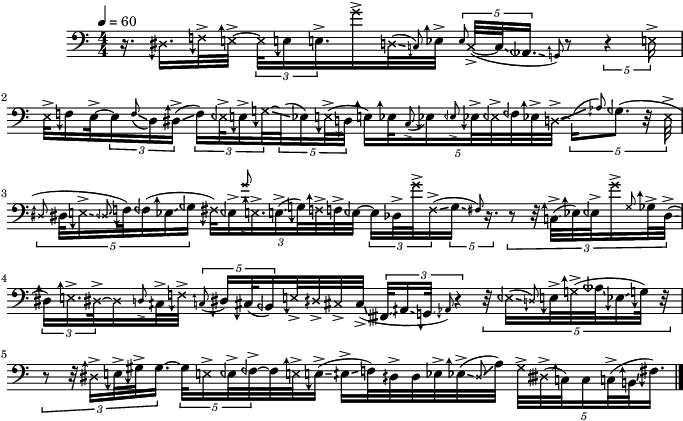

In [6]:
v = analysis.transcribe(unvoicedPitch="4G")
v.show()

## Playback

Below is a simple approach to sonify the transcription by defining different presets for sound which are fully voiced, partially voiced or completely unpitched. With more accurate feature detection regarding unpitched sections and formant prediction it might be possible to produce a much more accurate result

In [14]:
defPreset('unpitched', r"""
|icentroid, iq=20|
asig pinker
asig *= kamp
iband = icentroid / iq
aout1 resonr asig, icentroid, iband 
""")

defPreset("unvoiced", r"""
|icentroid, iq=20|
asig vco2 1, kfreq
anoise = pinker() * 0.1
iband = icentroid / iq
anoise resonr anoise, icentroid, iband 
aout1 = (asig + anoise) * kamp
""");

In [15]:
for n in v.items:
    if not n.getProperty('voiced', True):
        if n.getProperty('unvoicedGroup'):
            n.setPlay(instr='unpitched', args={'icentroid': n.getProperty('centroid')}, gain=1)
        else:
            n.setPlay(instr='unvoiced', args={'icentroid': n.getProperty('centroid')}, gain=1)

We load the original sound into a `Clip` in order to easily play it in sync with the analyisis

In [9]:
# cl = Clip((s0.samples, s0.sr))
cl = Clip(s.path)

mnOut size: 22
m_pitchTrack size: 22
mnOut size: 22
m_pitchTrack size: 22
mnOut size: 22
m_pitchTrack size: 22
mnOut size: 22
m_pitchTrack size: 22


Normally one would call `play` as in the cell below. In order for the generated audio to be playable online we render the result to disk

In [11]:
play(
    v.events(instr='saw', position=0, gain=2, sustain=0.05, fade=(0.0, 0.05), args={'kcutoffratio': 8}),
    cl.events(position=1, delay=0.)
);


OfflineRenderer(sr=44100)
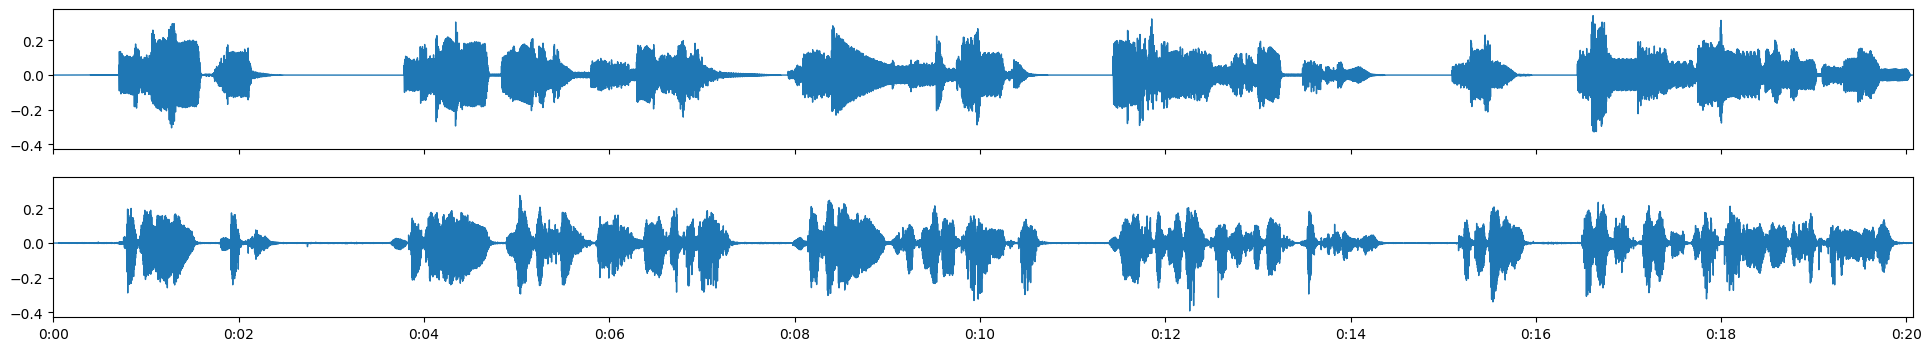

In [13]:
render('assets/transcription.ogg', [
    v.events(instr='saw', position=0, gain=2, sustain=0.05, fade=(0.0, 0.05), args={'kcutoffratio': 8}),
    cl.events(position=1, delay=0.05)
    
])
